### Import modules

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

# NYCOD

## Import

In [3]:
import pandas as pd
import numpy as np

#read in sales data, already subsetted to include Manhattan only
sales17 = pd.read_csv("INPUT_nycod/2017_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales18 = pd.read_csv("INPUT_nycod/2018_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales19 = pd.read_csv("INPUT_nycod/2019_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales20 = pd.read_csv("INPUT_nycod/2020_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales21 = pd.read_csv("INPUT_nycod/2021_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales22 = pd.read_csv("INPUT_nycod/rollingsales_manhattan.csv", skiprows=1, header=None).dropna(how='all')

#concatenate all dfs, check shape
allsales = pd.concat((sales17, sales18, sales19, sales20, sales21, sales22), axis=0)
allsales = allsales.iloc[:,0:21]
print(allsales.shape)

#add labels
labels = pd.DataFrame(pd.read_csv("INPUT_nycod/2021_manhattan.csv", header=6).columns).T
allsales = pd.concat((labels, allsales), axis=0)
allsales.columns = allsales.iloc[0] 
allsales = allsales[1:]

(110226, 21)


## Clean

### Dtype handling

In [4]:
#convert objects to numeric where possible
allsales['BOROUGH'] = allsales['BOROUGH'].astype(np.int64)
allsales['BLOCK'] = allsales['BLOCK'].astype(np.int64)
allsales['LOT'] = allsales['LOT'].astype(np.int64)
allsales['RESIDENTIAL\nUNITS'] = pd.to_numeric(allsales['RESIDENTIAL\nUNITS'].str.replace(',',''), errors='coerce')
allsales['TOTAL \nUNITS'] = pd.to_numeric(allsales['TOTAL \nUNITS'].str.replace(',',''), errors='coerce')
allsales['LAND \nSQUARE FEET'] = pd.to_numeric(allsales['LAND \nSQUARE FEET'].str.replace(',',''), errors='coerce')
allsales['GROSS \nSQUARE FEET'] = pd.to_numeric(allsales['GROSS \nSQUARE FEET'].str.replace(',',''), errors='coerce')
allsales['COMMERCIAL\nUNITS'] = pd.to_numeric(allsales['COMMERCIAL\nUNITS'], errors='coerce')
allsales['YEAR BUILT'] = pd.to_numeric(allsales['YEAR BUILT'], errors='coerce')

#clean sale price
prices = []
for i in allsales['SALE PRICE']:
    prices.append(float(i.replace(",", "").replace("'", "").replace("$", "")))
allsales['saleprice'] = prices
allsales = allsales.drop(columns=['SALE PRICE'])

#clean sale date, create 'years old at time of sale' variable
import datetime
dates = []
for i in allsales['SALE DATE']:
    dates.append(datetime.datetime.strptime(i, "%m/%d/%Y"))
allsales['saledate'] = dates
                 
years = []
for i in allsales['SALE DATE']:
    years.append(int(i[-4:]))
allsales['year_clean'] = years
allsales['bldg_age_at_sale_calc'] = allsales.year_clean - allsales['YEAR BUILT']
allsales = allsales.drop(columns=['YEAR BUILT'])
allsales = allsales.drop(columns=['SALE DATE'])
allsales = allsales.drop(columns=['year_clean'])

### Drop bad columns

In [5]:
#drop irrelevant and duplicate columns
allsales = allsales.drop(columns=['NEIGHBORHOOD',
                                  'BOROUGH', 
                                  'BUILDING CLASS CATEGORY', 
                                  'TAX CLASS AT PRESENT', 
                                  'BUILDING CLASS AT PRESENT',
                                  'TAX CLASS AT TIME OF SALE',
                                  'BUILDING CLASS\nAT TIME OF SALE',
                                  'EASE-MENT'])

#rename columns for interpretability
col_mapper = {'RESIDENTIAL\nUNITS':'units_residential',
             'COMMERCIAL\nUNITS':'units_commercial',
             'TOTAL \nUNITS':'units_total',
             'LAND \nSQUARE FEET': 'area_land',
             'GROSS \nSQUARE FEET': 'area_gross'}

allsales = allsales.rename(mapper=col_mapper, axis=1)

In [6]:
#lowercase and rename
allsales.columns = map(str.lower, allsales.columns)
allsales.columns = [i.replace('\n', " ").replace("  ", " ").replace(" ","") for i in allsales.columns]

allsales = allsales.drop(columns=['area_gross',
                     'area_land',
                     'units_total',
                     'apartmentnumber'])

### Drop bad rows (sale price == 0)

total observations: 110226
non-sale transfers (sale price 0): 21787
sales (sale price > 0): 88439


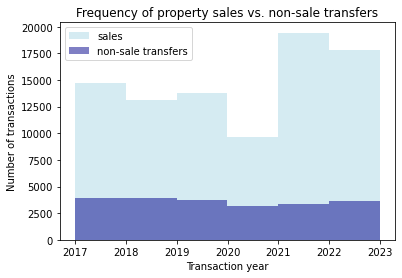

In [7]:
#FOR VIZ ONLY
#missing sale price
print("total observations: {}".format(len(allsales)))
print("non-sale transfers (sale price 0): {}".format(len(allsales[allsales['saleprice'] == 0])))
print("sales (sale price > 0): {}".format(len(allsales[allsales['saleprice'] > 0])))

import matplotlib.pyplot as plt
plt.hist(allsales[allsales.saleprice > 0].saledate, alpha=0.5, color='lightblue', label='sales', bins=6)
plt.hist(allsales[allsales.saleprice == 0].saledate, alpha=0.5, color='darkblue', label='non-sale transfers', bins=6)
plt.legend()
plt.title('Frequency of property sales vs. non-sale transfers')
plt.xlabel('Transaction year')
plt.ylabel('Number of transactions')
plt.savefig('OUTPUT_visualizations/1.Sales vs. non-sale transfers.png')
plt.show()

In [8]:
#SUBSET DATA
allsales_use = allsales[allsales['saleprice'] > 0]

#after removing zeros
allsales_use['log_saleprice'] = np.log(allsales_use.saleprice)
allsales_use = allsales_use.drop(columns=['saleprice'])

# PLUTO

## Import

In [9]:
pluto = pd.read_csv("INPUT_pluto/pluto_22v3_1.csv", low_memory=False)
pluto = pluto.dropna(how='all')

#subset to include Manhattan only
man = pluto[pluto['borough']=='MN']
print(man.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'INPUT_pluto/pluto_22v3_1.csv'

## Clean

### Dtype handling

In [9]:
#make list of PLUTO categorical columns
cate_cols = pd.DataFrame(man.dtypes)[pd.DataFrame(man.dtypes)[0] == 'object']

#create binary variables: ltdheight, splitzone, histdist, landmark
man['bin_ltdheight'] = abs(1-(man.ltdheight.isna()))
man['bin_splitzone'] = abs(1-(man.splitzone.isna()))
man['bin_histdist'] = abs(1-(man.histdist.isna()))
man['bin_landmark'] = abs(1-(man.landmark.isna()))

#drop all categoricals (including the ones we just recoded) but leave address to use for later recodes
cate_cols = cate_cols.drop('address')
man = man.drop(columns=cate_cols.index) 

print(man.shape)

(42695, 69)


### Add columns

In [10]:
#create FAR variable
man['far_calc'] = man['bldgarea'] / man['lotarea']
man = man.drop(columns=['bldgarea', 'lotarea'])

### Drop bad columns

In [11]:
#drop other irrelevant columns
man = man.drop(columns=['notes', 
                        'firm07_flag', 
                        'pfirm15_flag', 
                        'bctcb2020', 
                        'ct2010', 
                        'cb2010'])

In [12]:
#lowercase and rename
man.columns = map(str.lower, man.columns)
man.columns = [i.replace('\n', " ").replace("  ", " ").replace(" ","") for i in man.columns]

man = man.drop(columns=['xcoord',
                     'ycoord',
                     'borocode',
                     'plutomapid',
                     'sanitboro',
                     'unitsres',
                     'zipcode',
                     'areasource',
                     'bbl',
                     'builtfar',
                     'commfar',
                      'cd',
                     'facilfar',
                     'proxcode',
                     'residfar',
                     'taxmap',
                     'unitstotal',
                     'spdist3',
                     'landuse',
                     'easements',
                     'bsmtcode',
                     'assessland',
                     'assesstot',
                     'exempttot',
                     'condono',
                     'lottype',
                     'lotfront',
                     'lotdepth',
                     'bldgfront',
                     'bldgdepth',
                     'appbbl',
                     'tract2010'])

In [ ]:
man.columns

In [ ]:
#corr matrix of the district variables
import matplotlib.pyplot as plt
f = plt.figure(figsize=(14, 10))
plt.matshow(man[['policeprct', 'schooldist', 'healthcenterdistrict', 'sanitdistrict', 'council']].corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.xticks(range(0, 5, 1), ['policeprct', 'schooldist', 'healthcenterdistrict', 'sanitdistrict', 'council'], fontsize=10)
plt.yticks(range(0, 5, 1), ['policeprct', 'schooldist', 'healthcenterdistrict', 'sanitdistrict', 'council'], fontsize=10)
plt.title('Correlation between locational variables')
plt.savefig('OUTPUT_visualizations/2.District overlap.png')
plt.show()

In [13]:
binary_cols = ['policeprct','schooldist','healthcenterdistrict', 'sanitdistrict', 'council']
for i in binary_cols:
    man[i] = man[i].astype(object)
    
man.dtypes

block                     int64
lot                       int64
bct2020                 float64
schooldist               object
council                  object
policeprct               object
healthcenterdistrict     object
healtharea              float64
sanitdistrict            object
address                  object
comarea                 float64
resarea                 float64
officearea              float64
retailarea              float64
garagearea              float64
strgearea               float64
factryarea              float64
otherarea               float64
numbldgs                float64
numfloors               float64
yearbuilt               float64
yearalter1              float64
yearalter2              float64
latitude                float64
longitude               float64
bin_ltdheight             int32
bin_splitzone             int32
bin_histdist              int32
bin_landmark              int32
far_calc                float64
dtype: object

In [14]:
man = man[man.block < man.block.max()]
print(man.shape)

(42694, 30)


# Merge NYCOD and PLUTO

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(man.block, man.lot, label='Included in PLUTO', color='blue', marker='o')
plt.scatter(allsales_use.block, allsales_use.lot, label='Actual sales (NYCOD)', color='lightgray', alpha=0.1, marker='.')
plt.xlabel('Block code')
plt.ylabel('Lot code')
plt.title('Block-Lot codes covered by PLUTO')
plt.legend()
plt.savefig('OUTPUT_visualizations/3.Borough-Lot coverage.png')
plt.show()

In [15]:
for i in allsales_use.columns:
    if i in man.columns:
        print(i)
        
man = man.rename(mapper={'block':'block_pluto',
                        'lot':'lot_pluto',
                        'address':'address_pluto'}, axis=1)

block
lot
address


In [16]:
#join based on BBL

df_1 = allsales_use.merge(man, how='left', left_on=['block', 'lot'], right_on=['block_pluto', 'lot_pluto'])
print('Total transactions (from NYCOD): {}'.format(len(df_1)))
print("Successfully mapped to PLUTO via BBL: {:.3f}%".format(100*(len(df_1) - len(df_1[df_1.latitude.isna() == True]))/(len(df_1))))

Total transactions (from NYCOD): 88439
Successfully mapped to PLUTO via BBL: 49.474%


In [17]:
#join based on address

#isolate transactions that were not matched before
missed = df_1[df_1['latitude'].isna() == True].iloc[:,:10]

#clean address text
addresses = []
for i in missed.address:
    addresses.append(i.split(',')[0])
missed['address_clean'] = addresses

#merge on address
df_2 = missed.merge(man, how='left', left_on=['address_clean'], right_on=['address_pluto'])

print('Unmapped transactions (from NYCOD): {}'.format(len(df_2)))
print("Successfully mapped to PLUTO via address: {:.3f}%".format(100*(len(df_2) - len(df_2[df_2.latitude.isna() == True]))/(len(df_2))))

Unmapped transactions (from NYCOD): 49458
Successfully mapped to PLUTO via address: 37.420%


In [20]:
len_all = len(allsales_use)
len_bbl = len(df_1)
len_add = len(df_2)

df_1 = df_1[df_1.latitude.isna() == False].drop(columns=['address_pluto'])
df_2 = df_2[df_2.latitude.isna() == False].drop(columns=['address_clean', 'address_pluto'])

print('{} total sales'.format(len_all))
print('{} matched on BBL'.format(len_bbl))
print('{} matched on address'.format(len_add))
print('{} unmatched ({:.3f}% of total)'.format((len_all - len_bbl - len_add), 100*(len_all - len_bbl - len_add) / len_all))

df = pd.concat((df_1, df_2), axis=0)
#drop empty
df = df.dropna(how='all', axis=1)
df = df.dropna(how='all', axis=0)
#final df
print('\n')
print('shape of final df: {}'.format(df.shape))
df.head()

df.to_csv('OUTPUT_cleandata/df_clean.csv')

KeyError: "['address_pluto'] not found in axis"

In [ ]:
#'bct2020_pluto' is 2020 census tract if needed for tabulation

# Merge in distance datasets

In [ ]:
import pandas as pd

hospital = pd.read_csv('INPUT_distances/hospital dist.csv')
park = pd.read_csv('INPUT_distances/park dist.csv')
school = pd.read_csv('INPUT_distances/school dist.csv')
subway = pd.read_csv('INPUT_distances/subway dist.csv')

In [ ]:
dfs = [hospital, park, school, subway, df]

for i in dfs:
    print(i.shape)

In [ ]:
df['dist_park'] = park.iloc[:,-1:]
df['dist_subway'] = subway.iloc[:,-1:]
df['dist_hospital'] = hospital.iloc[:len(df), -1:]
df['dist_school'] = school.iloc[:len(df), -1:]

In [ ]:
df = df.drop(columns=['block_pluto_x', 'block_pluto_y', 'Unnamed: 0'])
df.head()

In [ ]:
df.to_csv('Data/OUTPUT_cleandata/df_dist.csv')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(df.dist_hospital, df.log_saleprice, color='pink', alpha=0.2, label='Distance to hospital')
plt.scatter(df.dist_school, df.log_saleprice, color='yellow', alpha=0.5, label='Distance to school')
plt.scatter(df.dist_subway, df.log_saleprice, color='orange', alpha=0.3, label='Distance to subway')
plt.scatter(df.dist_park, df.log_saleprice, color='green', alpha=0.5, label='Distance to park')
plt.xlabel('Distance measure')
plt.ylabel('Sale price')
plt.legend()
plt.show()

# Full dataset desc. statistics

In [ ]:
#drop empty rows and columns

In [19]:
#drop cols with more than 90% missing data
cols = pd.DataFrame(df.columns).rename(columns={0:'column_name'})
missing = []
for i in cols['column_name']:
    missing.append(100*df[i].isnull().sum()/len(df[i]))
cols['pct_missing'] = missing
to_drop = []
for i in cols.index:
    if cols['pct_missing'][i] > 90:
        to_drop.append(cols['column_name'][i])
df = df.drop(columns=to_drop)

print('Features with > 90% missing data: {} \n'.format(to_drop))
print('Features with any missing data:')
display(cols[cols['pct_missing']>0].sort_values('pct_missing', ascending=False))

Features with > 90% missing data: ['block_pluto_x'] 

Features with any missing data:


,column_name,pct_missing
38,block_pluto_x,99.950210
39,block_pluto_y,70.275132
4,units_residential,68.607957
5,units_commercial,58.171247
9,block_pluto,29.724868
27,numfloors,4.616052
7,bldg_age_at_sale_calc,3.954321
37,far_calc,3.596152
26,numbldgs,3.498177
24,factryarea,1.034355


In [ ]:
# plot corr matrix of all vars

f = plt.figure(figsize=(14, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation between independent variables')
plt.savefig('OUTPUT_visualizations/4.Corr matrix for all vars.png')
plt.show()

In [ ]:
#plot hist of sale prices

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['log_saleprice'])
plt.xlabel('Ln of sale price ($)')
plt.ylabel('Frequency')
plt.title('Manhattan residential real estate sales, 2017-2022')
plt.savefig('OUTPUT_visualizations/5.Histogram of ln sale price.png')
plt.show()

In [ ]:
df.describe()